In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# print(os.listdir("/kaggle/input/"))
# print(os.listdir("/kaggle/input/skin-cancer-mnist-ham10000/"))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
#read metadata
df_skin = pd.read_csv('HAM10000_metadata.csv')

df_skin.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [3]:
# lesion names are given in the description of the challenge
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

lesion_ID_dict = {
    'nv': 0,
    'mel': 1,
    'bkl': 2,
    'bcc': 3,
    'akiec': 4,
    'vasc': 5,
    'df': 6
}

lesion_names = ['Melanocytic nevi','Melanoma','Benign keratosis-like lesions ',
               'Basal cell carcinoma','Actinic keratoses','Vascular lesions',
               'Dermatofibroma']

lesion_names_short = ['nv','mel','bkl','bcc','akiec','vasc','df']

df_skin['lesion_type']=df_skin['dx'].map(lesion_type_dict)
df_skin['lesion_ID'] = df_skin['dx'].map(lesion_ID_dict)

print('Total number of images',len(df_skin))
print('The problem is unbalanced, since Melanocytic nevi is much more frequent that other labels')

df_skin['lesion_type'].value_counts()

Total number of images 10015
The problem is unbalanced, since Melanocytic nevi is much more frequent that other labels


lesion_type
Melanocytic nevi                  6705
Melanoma                          1113
Benign keratosis-like lesions     1099
Basal cell carcinoma               514
Actinic keratoses                  327
Vascular lesions                   142
Dermatofibroma                     115
Name: count, dtype: int64

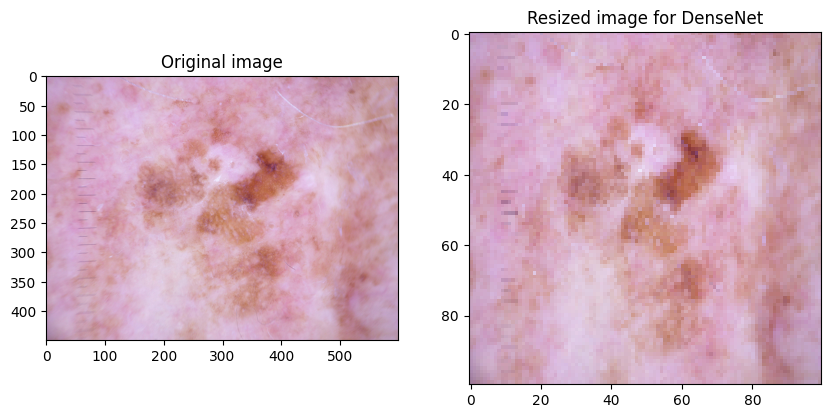

In [4]:
# read the first image
fname_images = np.array(df_skin['image_id'])
file_to_read ='./Dataset/HAM10000_images_part_1/'+str(fname_images[0])+'.jpg'

import cv2
from cv2 import imread, resize

img = imread(file_to_read)
img2 = resize(img,(100,100))

# show one exampe image

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img[:,:,::-1])
plt.title('Original image')
plt.subplot(1,2,2)
plt.imshow(img2[:,:,::-1])
plt.title('Resized image for DenseNet')
plt.show()

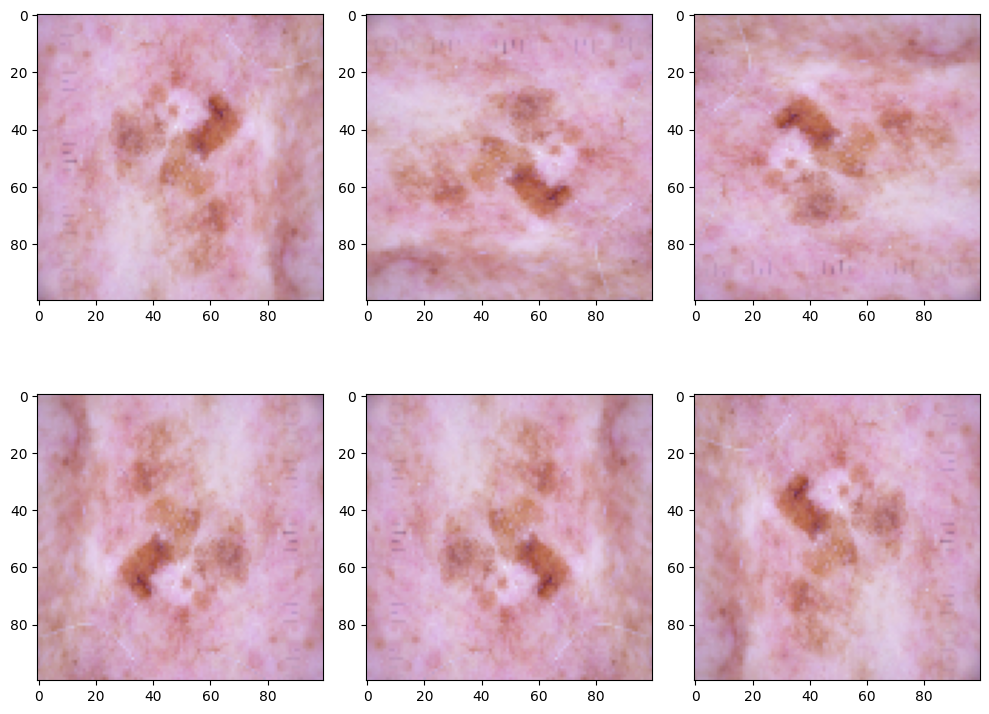

In [5]:
def produce_new_img(img2):
    # produce new images by rotating of flipping the original one
    # this helps to increase the dimension of the dataset, avoiding overfitting of a single class
    imga = cv2.rotate(img2,cv2.ROTATE_90_CLOCKWISE)
    imgb = cv2.rotate(img2,cv2.ROTATE_90_COUNTERCLOCKWISE)
    imgc = cv2.rotate(img2,cv2.ROTATE_180)
    imgd = cv2.flip(img2,0)
    imge = cv2.flip(img2,1)
    return imga,imgb,imgc,imgd,imge

new_img = produce_new_img(img2)

plt.figure(figsize=(10,8))
plt.subplot(2,3,1)
plt.imshow(img2[:,:,::-1])
for i in range(5):
    plt.subplot(2,3,2+i)
    plt.imshow(new_img[i][:,:,::-1])
plt.tight_layout()
plt.show()

In [6]:
# import images from 2 different folders

X = []
y = []

lista1 = os.listdir('./Dataset/HAM10000_images_part_1/')
lista2 = os.listdir('./Dataset/HAM10000_images_part_2/')


#import images from folder 1
for i in range(len(lista1)):
    fname_image = lista1[i]
    fname_ID = fname_image.replace('.jpg','')
    
    #features 
    file_to_read ='./Dataset/HAM10000_images_part_1/'+str(fname_image)
    img = imread(file_to_read)
    img2 = resize(img,(100,100))
    X.append(img2)
    
    #targets
    output = np.array(df_skin[df_skin['image_id'] == fname_ID].lesion_ID)
    y.append(output[0])
    
    # add more images for class between 1-6, rotating them 
    if output != 0:
        new_img = produce_new_img(img2)
        for i in range(5):
            X.append(new_img[i])
            y.append(output[0])
       
    if i % int(100) == 0:
        print(i,'images loaded')

# import images from folder 2
for i in range(len(lista2)):
    fname_image = lista2[i]
    fname_ID = fname_image.replace('.jpg','')
    
    #features
    file_to_read ='./Dataset/HAM10000_images_part_2/'+str(fname_image)
    img = imread(file_to_read)
    img2 = resize(img,(100,100))
    X.append(img2)
    
    #targets
    output = np.array(df_skin[df_skin['image_id'] == fname_ID].lesion_ID)
    y.append(output[0])
    
    # add more images for class between 1-6
    if output != 0:
        new_img = produce_new_img(img2)
        for i in range(5):
            X.append(new_img[i])
            y.append(output[0])
    
    if i % int(100) == 0:

        print(len(lista1)+i,'images loaded')

0 images loaded
100 images loaded
200 images loaded
300 images loaded
600 images loaded
700 images loaded
800 images loaded
900 images loaded
1000 images loaded
1100 images loaded
1200 images loaded
1400 images loaded
1500 images loaded
1700 images loaded
1800 images loaded
2000 images loaded
2100 images loaded
2400 images loaded
2500 images loaded
2600 images loaded
2800 images loaded
2900 images loaded
3100 images loaded
3600 images loaded
3700 images loaded
3900 images loaded
4200 images loaded
4300 images loaded
4400 images loaded
4500 images loaded
4600 images loaded
4700 images loaded
4800 images loaded
5000 images loaded
5200 images loaded
5400 images loaded
5500 images loaded
5600 images loaded
5700 images loaded
5900 images loaded
6000 images loaded
6100 images loaded
6200 images loaded
6600 images loaded
6700 images loaded
6800 images loaded
6900 images loaded
7000 images loaded
7300 images loaded
7500 images loaded
7600 images loaded
7800 images loaded
8100 images loaded
820

In [7]:
from keras.utils import to_categorical

X = np.array(X)
y = np.array(y)

y_train = to_categorical(y, num_classes=7)

# #convert targets in dummy variables, as required by softmax activation function
# y_dumm = np.array(pd.get_dummies(y))

In [8]:
from sklearn.model_selection import train_test_split

# split in 80% training and 20% test data
X_train, X_test, y_train, y_test = train_test_split(X, y_train, test_size=0.33, random_state=50,stratify=y)


print('Train dataset shape',X_train.shape)
print('Test dataset shape',X_test.shape)

Train dataset shape (17798, 100, 100, 3)
Test dataset shape (8767, 100, 100, 3)


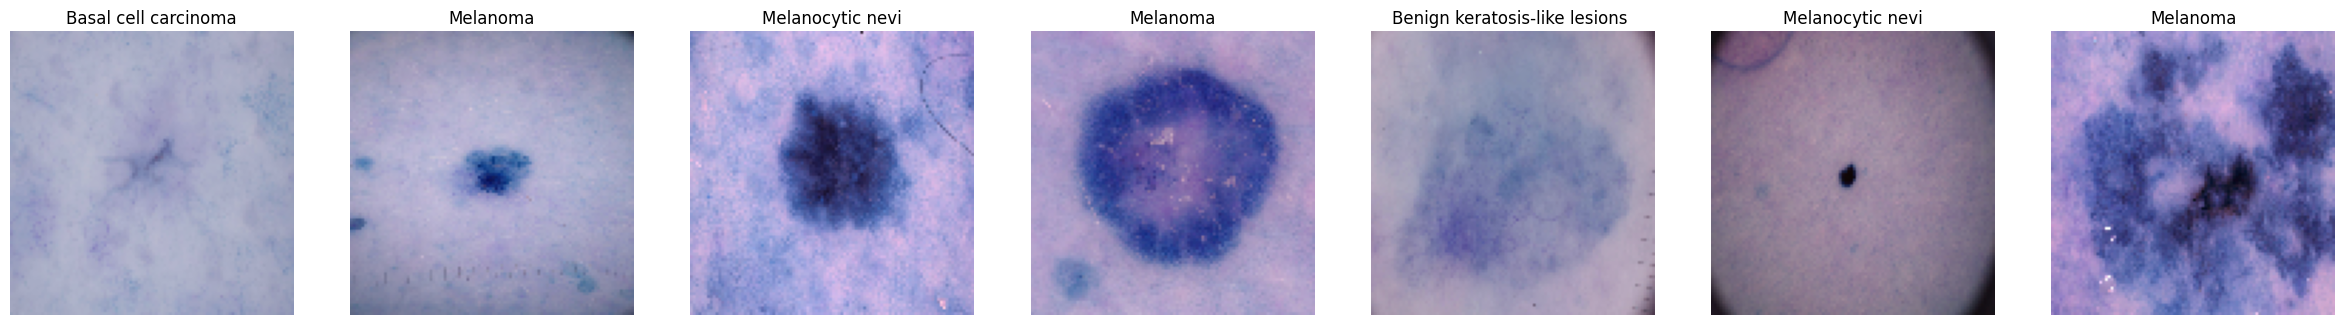

In [9]:
fig, ax = plt.subplots(1, 7, figsize=(30, 30))
for i in range(7):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(lesion_names[np.argmax(y_train[i])])

In [10]:
import keras
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.layers import Dropout, Activation
from keras.layers import Conv2D,BatchNormalization,MaxPool2D,Flatten,Dense

In [11]:
from sklearn.utils.class_weight import compute_class_weight
y_id = np.array(df_skin['lesion_ID'])

# compute weights for the loss function, because the problem is unbalanced
class_weights = np.around(compute_class_weight(class_weight='balanced',classes=np.unique(y_id),y=y),2)
class_weights = dict(zip(np.unique(y_id),class_weights))

print('The problem is unbalanced. We need to provide class_weights ')
print(class_weights)

The problem is unbalanced. We need to provide class_weights 
{0: 0.57, 1: 0.57, 2: 0.58, 3: 1.23, 4: 1.93, 5: 4.45, 6: 5.5}


In [12]:
# building Neural Network

import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Input, Activation, Dropout, GlobalAveragePooling2D, \
    BatchNormalization, concatenate, AveragePooling2D
from keras.optimizers import Adam

model = Sequential([
    
    # 1st convolutional layer
    Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(100,100,3)),
    BatchNormalization(),
    MaxPool2D(pool_size=(3,3), strides=(2,2)),
    
    # 2nd convolutional layer
    Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPool2D(pool_size=(3,3), strides=(2,2)),
    
    # 3rd convolutional layer
    Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    
    # 4th convolutional layer
    Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    
    # 5th convolutional layer
    Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPool2D(pool_size=(3,3), strides=(2,2)),
    
    Flatten(),
    
    # 6th, Dense layer
    Dense(4096, activation='relu'),
    Dropout(0.5),
    
    # 7th Dense layer
    Dense(4096, activation='relu'),
    Dropout(0.5),
    
    # 8th output layer
    Dense(7, activation='softmax')
])

c:\Users\manan\anaconda3\envs\DPL\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
# training
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

early_stopping_monitor = EarlyStopping(patience=100,monitor='val_accuracy')
model_checkpoint_callback = ModelCheckpoint(filepath='model.keras',
                                            save_weights_only=False,
                                            monitor='val_accuracy',
                                            mode='auto',
                                            save_best_only=True,
                                            verbose=1)
batch_size = 32
epochs = 100
optimizer = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-3)
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics=['accuracy'])

datagen = ImageDataGenerator(zoom_range = 0.2, horizontal_flip=True, shear_range=0.2)

datagen.fit(X_train)

history=model.fit(datagen.flow(X_train,y_train), epochs=epochs, batch_size=batch_size, shuffle=True, callbacks=[early_stopping_monitor,model_checkpoint_callback], validation_data=(X_test, y_test), class_weight=class_weights)

Epoch 1/100


c:\Users\manan\anaconda3\envs\DPL\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


557/557 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.3378 - loss: 2.0243
Epoch 1: val_accuracy improved from -inf to 0.23760, saving model to model.keras
557/557 ━━━━━━━━━━━━━━━━━━━━ 272s 475ms/step - accuracy: 0.3379 - loss: 2.0237 - val_accuracy: 0.2376 - val_loss: 2.9226
Epoch 2/100
557/557 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.4671 - loss: 1.3886
Epoch 2: val_accuracy improved from 0.23760 to 0.41588, saving model to model.keras
557/557 ━━━━━━━━━━━━━━━━━━━━ 275s 492ms/step - accuracy: 0.4671 - loss: 1.3885 - val_accuracy: 0.4159 - val_loss: 1.5845
Epoch 3/100
557/557 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.5186 - loss: 1.2079
Epoch 3: val_accuracy did not improve from 0.41588
557/557 ━━━━━━━━━━━━━━━━━━━━ 226s 404ms/step - accuracy: 0.5187 - loss: 1.2079 - val_accuracy: 0.2994 - val_loss: 1.9517
Epoch 4/100
557/557 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.5370 - loss: 1.1273
Epoch 4: val_accuracy improved from 0.41588 to 0.51557, saving model to model

In [14]:
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

274/274 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8094 - loss: 0.6332
Accuracy: 81.01%


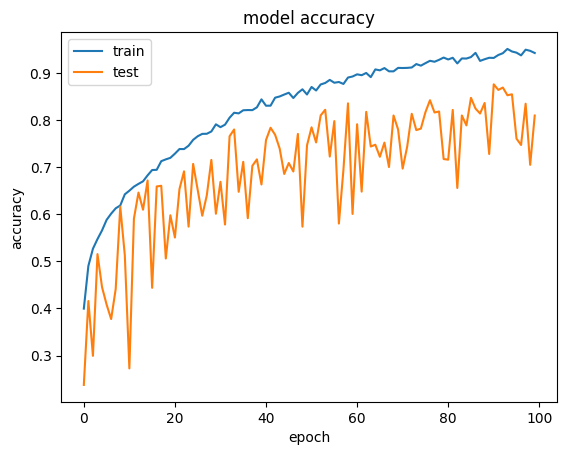

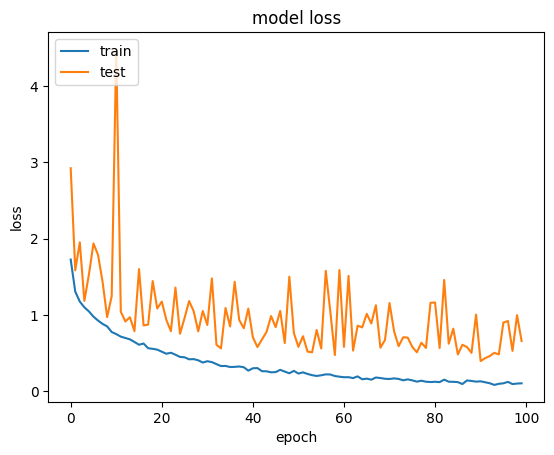

In [15]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [16]:
y_pred = model.predict(X_test)

total = 0
accurate = 0
accurateindex = []
wrongindex = []

for i in range(len(y_pred)):
    if np.argmax(y_pred[i]) == np.argmax(y_test[i]):
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)
        
    total += 1
    
print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)

print('Accuracy:', round(accurate/total*100, 3), '%')

274/274 ━━━━━━━━━━━━━━━━━━━━ 15s 53ms/step
Total-test-data; 8767 	accurately-predicted-data: 7102 	 wrongly-predicted-data:  1665
Accuracy: 81.008 %


In [18]:
best_model = load_model('model.keras')

# compute predictions
y_pred_prob = np.around(best_model.predict(X_test),3)
y_pred = np.argmax(y_pred_prob,axis=1)

y_test2 = np.argmax(y_test,axis=1)

274/274 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step


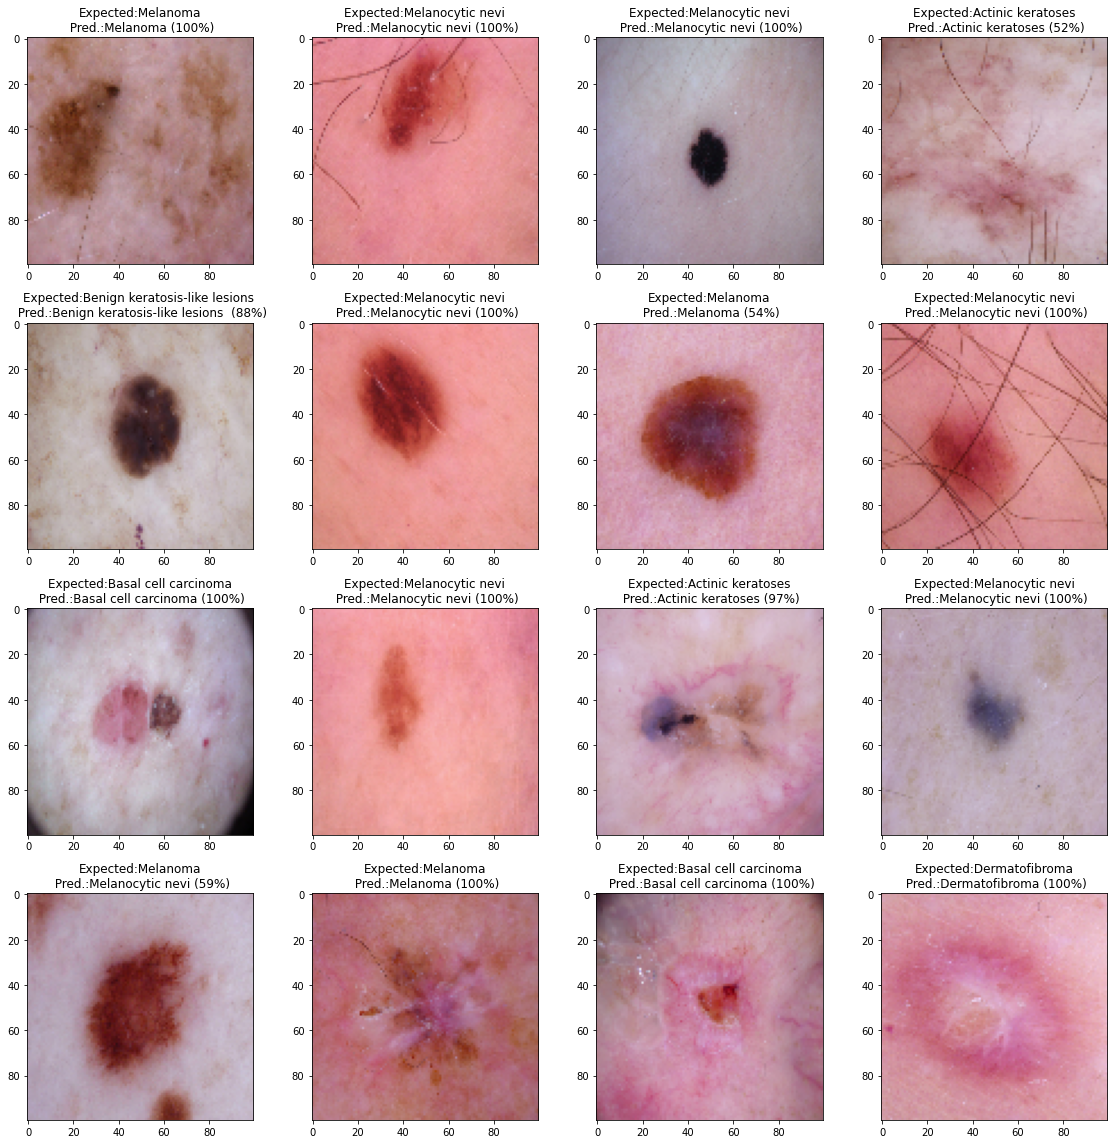

In [ ]:
plt.figure(figsize=(16,16))
for i in range(16):
    plt.subplot(4,4,i+1)
    index = i+100
    plt.imshow(X_test[index,:,:,::-1])
    label_exp = lesion_names[y_test2[index]]  #expected label
    label_pred = lesion_names[y_pred[index]]  #predicted label
    label_pred_prob = round(np.max(y_pred_prob[index])*100)
    plt.title('Expected:'+str(label_exp)+'\n Pred.:'+str(label_pred)+' ('+str(label_pred_prob)+'%)')
plt.ylabel('')
plt.tight_layout()
plt.savefig('final_figure.png',dpi=300)
plt.show()

In [19]:
print('Accuracy for label equal to 0')
print(np.mean(y_test2[y_test2 == 0] == y_pred[y_test2 == 0]))

print('Accuracy for label different from 0')
print(np.mean(y_test2[y_test2 != 0] == y_pred[y_test2 != 0]))

Accuracy for label equal to 0
0.8409399005874378
Accuracy for label different from 0
0.8883124809276778


In [20]:
acc_tot= []

for i in range(7):
    acc_parz = round(np.mean(y_test2[y_test2 == i] == y_pred[y_test2 == i]),2)
    lab_parz = lesion_names[i]
    print('accuracy for',lab_parz,'=',acc_parz)
    acc_tot.append(acc_parz)

accuracy for Melanocytic nevi = 0.84
accuracy for Melanoma = 0.91
accuracy for Benign keratosis-like lesions  = 0.84
accuracy for Basal cell carcinoma = 0.95
accuracy for Actinic keratoses = 0.81
accuracy for Vascular lesions = 0.99
accuracy for Dermatofibroma = 0.93


In [21]:
acc_tot = np.array(acc_tot)
freq = np.unique(y_test2,return_counts=True)[1]

np.sum(acc_tot*freq)/np.sum(freq)

0.8753051214782707

In [4]:
import tensorflow as tf

# Load the Keras model
model = tf.keras.models.load_model('./model_87.keras')

# Convert the model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model
tflite_model_file = "./skin_disease.tflite"
with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

print("Model successfully converted and saved as", tflite_model_file)


INFO:tensorflow:Assets written to: C:\Users\manan\AppData\Local\Temp\tmp8qi997w7\assets


INFO:tensorflow:Assets written to: C:\Users\manan\AppData\Local\Temp\tmp8qi997w7\assets


Saved artifact at 'C:\Users\manan\AppData\Local\Temp\tmp8qi997w7'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  2670552299680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2670552435872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2670552445728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2670552447488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2670552441152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2670552443440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2670552443264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2670552228512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2670552230976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2670552232736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  267055